# Agentic Approach to Our Data Modeling Copilot

AI Agents are autonomous systems designed to complete repetitive work that would otherwise be done by a human. We can use LangGraph to create agents that will operate in a certain flow according to a graph we compile of various nodes and edges. These can have different conditional requirements to execute or loop through for a better overall response from an LLM. We will also be incorporating tools within our agents. Tools are essentially functions made available to an LLM that can be called by the LLM in order to execute specific tasks like an API call, data preprocessing, data validation, and so on.

### **Setup**

In [12]:
import sys
from pathlib import Path
sys.path.append('src/')

import utils
from langgraph.graph import StateGraph, END
from typing import TypedDict, List, Dict, Any, AsyncGenerator
import json
import warnings

# Ignore Warnings
warnings.filterwarnings("ignore")

### **Plan of Action**

We will attempt to create 4 seperate agents which will work together to complete our end goal of data modeling.

1. DocumentProcessor Agent
   - Processes data modeling guidelines
   - Manages vector store updates
   - Retrieves relevant context

2. SchemaAnalyzer Agent
   - Analyzes CSV schema
   - Identifies column patterns
   - Queries knowledge graph

3. StandardsEnforcer Agent
   - Applies naming conventions
   - Validates data types
   - Ensures consistency

4. QualityChecker Agent
   - Validates transformations
   - Checks business rules
   - Suggests improvements

In [2]:
# Define our state type
class AgentState(TypedDict):
    column_name: str
    original_schema: Dict[str, Any]
    retrieved_context: List[str]
    proposed_changes: Dict[str, Any]
    validation_results: Dict[str, Any]
    final_output: Dict[str, Any]


In [3]:
print("Initializing components...")
model_loader = utils.ModelLoader()
vector_store = utils.VectorStoreManager()
graph_manager = utils.KnowledgeGraphManager()

Initializing components...


In [4]:
print("\nLoading models...")
llm, tokenizer = model_loader.load_flan_t5()
embedding_model = model_loader.load_mpnet()
knowledge_graph = graph_manager.load_graph()

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565



Loading models...


No sentence-transformers model found with name ../models/all-mpnet-base-v2. Creating a new one with mean pooling.


In [5]:
print("\nSetting up vector store...")
try:
    # First explicitly delete if exists
    try:
        vector_store.client.delete_collection("data_modeling_rules_mpnet")
        print("Deleted existing collection")
    except Exception as e:
        print(f"No existing collection to delete: {e}")

    # Wait a moment to ensure cleanup
    import time
    time.sleep(1)
    
    # Create new collection
    collection = vector_store.client.create_collection(
        name="data_modeling_rules_mpnet",
        metadata={"description": "Data modeling standards with MPNet embeddings"}
    )
    print("Created new collection")
    
    print("\nLoading guidelines...")
    guidelines = utils.DataProcessor.chunk_guidelines("../data/raw/data_modeling_guidelines.txt")
    print(f"Found {len(guidelines)} guideline chunks")
    
    print("\nGenerating embeddings...")
    embeddings = embedding_model.encode(guidelines)
    ids = [f"guideline_{i}" for i in range(len(guidelines))]
    
    print("\nAdding to collection...")
    collection.add(
        embeddings=embeddings.tolist(),
        documents=guidelines,
        ids=ids,
        metadatas=[{"source": "guidelines", "chunk": i} for i in range(len(guidelines))]
    )
    print("✓ Vector store setup complete")
    
except Exception as e:
    print(f"Error during setup: {e}")
    raise


Setting up vector store...
No existing collection to delete: Collection data_modeling_rules_mpnet does not exist.
Created new collection

Loading guidelines...
Found 9 guideline chunks

Generating embeddings...

Adding to collection...
✓ Vector store setup complete


In [16]:
class DocumentProcessorAgent:
    def __init__(self, embedding_model, collection):
        self.embedding_model = embedding_model
        self.collection = collection
    
    def __call__(self, state: AgentState) -> AgentState:
        """Process guidelines and retrieve relevant context"""
        query_embedding = self.embedding_model.encode([state["column_name"]])
        results = self.collection.query(
            query_embeddings=query_embedding.tolist(),
            n_results=2
        )
        
        state["retrieved_context"] = results['documents'][0]
        return state

In [17]:
class SchemaAnalyzerAgent:
    def __init__(self, knowledge_graph):
        self.knowledge_graph = knowledge_graph
    
    def __call__(self, state: AgentState) -> AgentState:
        """Analyze column and query knowledge graph"""
        node_type, properties = utils.KnowledgeGraphManager.find_column_type(
            self.knowledge_graph,
            state["column_name"]
        )
        
        state["proposed_changes"] = {
            "data_type": node_type,
            "properties": properties
        }
        return state

In [18]:
class StandardsEnforcerAgent:
    def __init__(self, llm, tokenizer):
        self.llm = llm
        self.tokenizer = tokenizer
    
    def __call__(self, state: AgentState) -> AgentState:
        """Apply standards and generate suggestions"""
        context = "\n".join(state["retrieved_context"])
        properties = json.dumps(state["proposed_changes"])
        
        prompt = f"""Based on these guidelines:
{context}

And these properties:
{properties}

Standardize this column name: {state["column_name"]}
"""
        
        inputs = self.tokenizer(prompt, return_tensors="pt")
        if torch.backends.mps.is_available():
            inputs = {k: v.to('mps') for k, v in inputs.items()}
        
        outputs = self.llm.generate(**inputs, max_length=50)
        result = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
        
        state["final_output"] = {
            "original_name": state["column_name"],
            "suggested_name": result,
            "data_type": state["proposed_changes"]["data_type"],
            "properties": state["proposed_changes"]["properties"]
        }
        return state

In [19]:
# Create workflow
workflow = StateGraph(AgentState)

In [20]:
# Add nodes - now they're callable
workflow.add_node("process_documents", DocumentProcessorAgent(embedding_model, collection))
workflow.add_node("analyze_schema", SchemaAnalyzerAgent(knowledge_graph))
workflow.add_node("enforce_standards", StandardsEnforcerAgent(llm, tokenizer))

# Add edges
workflow.add_edge('process_documents', 'analyze_schema')
workflow.add_edge('analyze_schema', 'enforce_standards')
workflow.add_edge('enforce_standards', END)  # Add explicit end

# Set entry point
workflow.set_entry_point("process_documents")

# Compile workflow
app = workflow.compile()

In [21]:
def test_workflow():
    test_columns = [
        "feat_imp_age",
        "model_score",
        "dt_last_active",
        "cust_id"
    ]
    
    results = []
    for column in test_columns:
        initial_state = AgentState(
            column_name=column,
            original_schema={},
            retrieved_context=[],
            proposed_changes={},
            validation_results={},
            final_output={}
        )
        
        final_state = app.invoke(initial_state)
        results.append(final_state["final_output"])
        print(f"\nResults for {column}:")
        print(json.dumps(final_state["final_output"], indent=2))
    
    return results

Mermaid Graph Definition:
%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	process_documents(process_documents)
	analyze_schema(analyze_schema)
	enforce_standards(enforce_standards)
	__end__([<p>__end__</p>]):::last
	__start__ --> process_documents;
	analyze_schema --> enforce_standards;
	enforce_standards --> __end__;
	process_documents --> analyze_schema;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc


Rendered Graph:


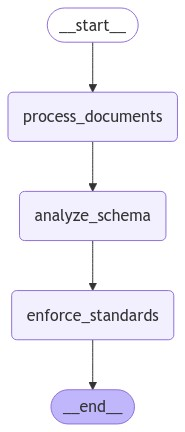

In [25]:
# Visualize LangGraph workflow using Mermaid
print("Mermaid Graph Definition:")
print(app.get_graph().draw_mermaid())

print("\nRendered Graph:")
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

# Simplified visualization without custom styling
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [27]:
import torch

results = test_workflow()


Results for feat_imp_age:
{
  "original_name": "feat_imp_age",
  "suggested_name": "----------------------------------------------------------------------------------------------------------------------------------------------",
  "data_type": "FEATURE_IMPORTANCE",
  "properties": {
    "type": "NUMBER(10,8)",
    "nullability": "N",
    "pattern": [
      "feat.*imp",
      "importance"
    ],
    "category": "ML_DOMAIN",
    "requires": [
      "SCORE",
      "METADATA"
    ],
    "format": "NUMBER(10,8)",
    "description": "Measure of feature contribution to model"
  }
}

Results for model_score:
{
  "original_name": "model_score",
  "suggested_name": "Model",
  "data_type": "MODEL_SCORE",
  "properties": {
    "requires": [
      "CONFIDENCE",
      "METADATA"
    ],
    "format": "NUMBER(10,8)",
    "description": "Model prediction score",
    "pattern": [
      "model.*score",
      "prediction"
    ],
    "category": "ML_DOMAIN"
  }
}

Results for dt_last_active:
{
  "original


Rendered Graph:


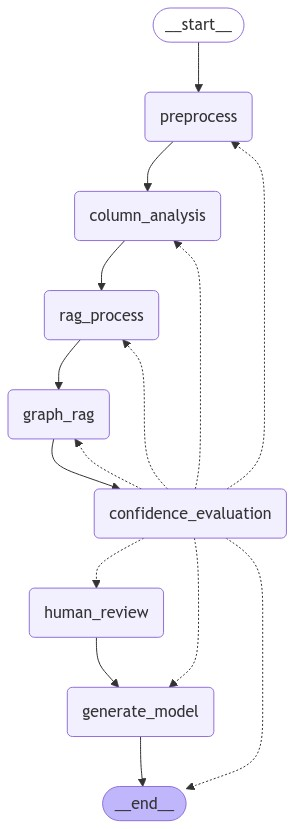

In [43]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Dict
from IPython.display import Image, display

# Define state
class AgentState(TypedDict):
    input_type: str
    column_name: str
    validate_length: bool
    rag_context: Dict
    graph_results: Dict
    confidence_score: float
    output_format: str
    final_output: Dict

# Create workflow
workflow = StateGraph(AgentState)

# Add nodes (placeholders for actual implementations)
workflow.add_node("preprocess", lambda x: x)
workflow.add_node("column_analysis", lambda x: x)
workflow.add_node("rag_process", lambda x: x)
workflow.add_node("graph_rag", lambda x: x)
workflow.add_node("confidence_evaluation", lambda x: x)
workflow.add_node("human_review", lambda x: x)
workflow.add_node("generate_model", lambda x: x)

# Define conditional edge function for confidence evaluation
def confidence_router(state: AgentState) -> str:
    return "generate_model" if state.get("confidence_score", 0) > 0.8 else "human_review"

# Add edges with simplified conditional logic
workflow.add_edge("preprocess", "column_analysis")
workflow.add_edge("column_analysis", "rag_process")
workflow.add_edge("rag_process", "graph_rag")
workflow.add_edge("graph_rag", "confidence_evaluation")
workflow.add_conditional_edges("confidence_evaluation", confidence_router)
workflow.add_edge("human_review", "generate_model")
workflow.add_edge("generate_model", END)

# Set entry point
workflow.set_entry_point("preprocess")

# Compile workflow
app = workflow.compile()

# Visualize
print("\nRendered Graph:")
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)